In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [1]:
prices = pd.read_csv('binance_data/BTC_Cross_Currencies/2025/1m/BTCEUR_2025_1m.csv', parse_dates=["Open Time"], index_col="Open Time")

NameError: name 'pd' is not defined

In [4]:
#Print first 20 rows of prices dataframe

print(prices.head(20))

prices

                         Open      High       Low     Close   Volume  \
Open Time                                                              
2025-01-01 00:00:00  90197.71  90222.83  90173.74  90206.04  0.08840   
2025-01-01 00:01:00  90248.70  90278.19  90224.42  90270.49  0.63981   
2025-01-01 00:02:00  90278.18  90329.12  90270.52  90329.12  0.14812   
2025-01-01 00:03:00  90303.55  90303.55  90278.20  90302.77  0.04056   
2025-01-01 00:04:00  90298.02  90298.02  90279.64  90291.57  0.06448   
2025-01-01 00:05:00  90279.62  90290.25  90279.62  90290.25  0.02686   
2025-01-01 00:06:00  90288.81  90288.81  90224.14  90224.14  0.04098   
2025-01-01 00:07:00  90252.00  90252.00  90226.78  90226.78  0.02158   
2025-01-01 00:08:00  90218.06  90230.20  90218.06  90230.20  0.05069   
2025-01-01 00:09:00  90230.21  90230.21  90230.21  90230.21  0.00053   
2025-01-01 00:10:00  90233.62  90240.65  90206.04  90206.04  0.04389   
2025-01-01 00:11:00  90150.58  90150.58  90129.98  90130.00  0.0

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Volume,Taker Buy Quote Volume,Ignore
Open Time,,,,,,,,,,,
2025-01-01 00:00:00,90197.71,90222.83,90173.74,90206.04,0.08840,2025-01-01 00:00:59.999,7972.812608,14,0.02746,2476.210790,0
2025-01-01 00:01:00,90248.70,90278.19,90224.42,90270.49,0.63981,2025-01-01 00:01:59.999,57747.610161,50,0.61757,55740.603635,0
2025-01-01 00:02:00,90278.18,90329.12,90270.52,90329.12,0.14812,2025-01-01 00:02:59.999,13374.660595,19,0.05044,4554.421409,0
2025-01-01 00:03:00,90303.55,90303.55,90278.20,90302.77,0.04056,2025-01-01 00:03:59.999,3662.556133,8,0.03440,3106.374303,0
2025-01-01 00:04:00,90298.02,90298.02,90279.64,90291.57,0.06448,2025-01-01 00:04:59.999,5822.010259,12,0.00176,158.904297,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 23:55:00,81426.99,81427.93,81388.21,81388.21,0.00577,2025-02-28 23:55:59.999,469.785100,10,0.00468,381.029169,0
2025-02-28 23:56:00,81376.58,81376.58,81375.96,81375.96,0.04662,2025-02-28 23:56:59.999,3793.747299,4,0.04662,3793.747299,0
2025-02-28 23:57:00,81361.99,81361.99,81340.23,81340.23,0.01345,2025-02-28 23:57:59.999,1094.254365,8,0.00007,5.695339,0


In [2]:
resample_data('binance_data/BTC_Cross_Currencies/2025/1m', '5T', 'binance_data/BTC_Cross_Currencies/2025/5m/BTCEUR_2025_5m.csv')

📂 Found 3 CSV files. Converting to 5T-minute timeframe...
✅ Converted BTCEUR_2025_1m.csv -> binance_data/BTC_Cross_Currencies/2025/5m/BTCEUR_2025_5m.csv/BTCEUR_2025_5T.csv


/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/data_pre_processing.py:258: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(timeframe).agg({
/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/data_pre_processing.py:258: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(timeframe).agg({


✅ Converted BTCUSDT_2025_1m.csv -> binance_data/BTC_Cross_Currencies/2025/5m/BTCEUR_2025_5m.csv/BTCUSDT_2025_5T.csv
✅ Converted BTCJPY_2025_1m.csv -> binance_data/BTC_Cross_Currencies/2025/5m/BTCEUR_2025_5m.csv/BTCJPY_2025_5T.csv
🎉 Conversion complete!


/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/data_pre_processing.py:258: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample(timeframe).agg({


In [5]:
#Create a new dataframe by getting every 5th row of the original dataframe
# Resample the data to 5-minute frequency.
# '5T' is the offset alias for 5 minutes.
df_5min = prices.resample("5T").agg({
    "Open": "first",  # first value in the 5-minute period
    "High": "max",    # highest value in the 5-minute period
    "Low": "min",     # lowest value in the 5-minute period
    "Close": "last",  # last value in the 5-minute period
    "Volume": "sum"   # sum of volumes over the period
})

# Optionally, drop any periods where the market was closed (if any row has a NaN in 'Open')
df_5min.dropna(subset=["Open"], inplace=True)

print("\n5-minute resampled data:")
print(df_5min.head(20))



5-minute resampled data:
                         Open      High       Low     Close   Volume
Open Time                                                           
2025-01-01 00:00:00  90197.71  90329.12  90173.74  90291.57  0.98137
2025-01-01 00:05:00  90279.62  90290.25  90218.06  90230.21  0.14064
2025-01-01 00:10:00  90233.62  90262.17  90114.05  90262.17  0.32542
2025-01-01 00:15:00  90265.46  90499.91  90242.98  90399.22  2.10740
2025-01-01 00:20:00  90417.62  90518.10  90307.68  90339.06  1.71535
2025-01-01 00:25:00  90350.40  90377.31  90325.60  90372.24  0.31417
2025-01-01 00:30:00  90372.71  90559.82  90372.71  90491.21  0.58805
2025-01-01 00:35:00  90486.65  90518.81  90448.71  90518.68  0.84058
2025-01-01 00:40:00  90509.91  90555.51  90482.28  90499.86  0.21234
2025-01-01 00:45:00  90500.06  90594.92  90474.35  90594.92  0.24636
2025-01-01 00:50:00  90575.56  90895.43  90575.41  90842.79  0.48248
2025-01-01 00:55:00  90819.57  91053.12  90801.89  90993.08  1.23911
2025-01-

/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_14022/607770238.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = prices.resample("5T").agg({


In [6]:
merge_ohlc_closing_prices('binance_data/BTC_Cross_Currencies/2024/1m')

⚠️ Skipping merged_closing_prices.csv - Required columns missing
⚠️ Detected 476 missing values across the dataset.
   - BTC/USDT_2024_1m: 284 missing values
   - BTCEUR_2024_1m: 192 missing values
✅ All missing values have been successfully filled.


/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/data_pre_processing.py:190: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)
/Users/alexandrosdupreez/Documents/GitHub/PairsTrading/data_pre_processing.py:191: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='bfill', inplace=True)


✅ Merged file saved as: binance_data/BTC_Cross_Currencies/2024/1m/merged_closing_prices.csv


,timestamp,BTC/USDT_2024_1m,BTCJPY_2024_1m,BTCEUR_2024_1m
0,2024-04-01 00:00:00,71186.00,10778951.0,66048.23
1,2024-04-01 00:01:00,71220.01,10782339.0,66083.17
2,2024-04-01 00:02:00,71155.92,10778951.0,66013.37
3,2024-04-01 00:03:00,71223.07,10778951.0,66071.34
4,2024-04-01 00:04:00,71233.42,10778680.0,66082.50
...,...,...,...,...
395969,2024-12-31 23:55:00,93667.52,14722497.0,90292.00
395970,2024-12-31 23:56:00,93636.37,14722497.0,90264.74
395971,2024-12-31 23:57:00,93616.04,14719431.0,90247.77
395972,2024-12-31 23:58:00,93600.00,14720928.0,90228.24


In [7]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m

In [8]:
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/30m/merged_closing_prices.csv", index_col=0, parse_dates=True)

#prices = pd.read_csv("binance_data/Staked_ETH_Bybit/merged_closing_prices.csv", index_col=0, parse_dates=True)

#prices = pd.read_csv("binance_data/From_Paper/2023/1m/merged_From_Paper_closing_prices_OCT_NOV.csv", index_col=0, parse_dates=True)

prices = pd.read_csv('binance_data/BTC_Cross_Currencies/2025/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: 'binance_data/BTC_Cross_Currencies/2025/1m/merged_closing_prices.csv'

In [9]:
#get prices for dates greater than or equal to 2024-01-01 16:30:00	

#prices = prices.loc[prices.index >= "2024-01-01 16:30:00"]

# Trading simulation
---

* ## In-Sample Testing

In [10]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m


crypto_1 = prices.columns[0]
crypto_2 = prices.columns[1]

cointegrated_pairs = [(crypto_1,
  crypto_2,
  0.731393,
  0.8501886494196308,
  0.22)]

In [11]:
#Params:
window_size = 1440
entry_threshold= 2
exit_threshold=0
stop_loss_threshold= 100

In [12]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits, price_changes_S1, price_changes_S2 = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)




Testing strategy on pair: BTCEUR_2025_1m and BTCJPY_2025_1m ...
Total trades closed: 219 (Wins=219, Losses=0)
Win rate: 1.00


In [13]:
# plt.hist(zscore_series, bins=50)

In [14]:
# #Compute normalised difference between the two prices
# normalised_abs_diff = np.abs((S1 - S2) / (S1 + S2))

# #Compute the average normalised difference
# np.mean(normalised_abs_diff)

In [15]:
# #SETH and ETH Distance: 0.0003968226419110906

# s_eth_distance = 0.0003968226419110906
# w_bitcoin_distance = 0.0006442955592394416

# percentage = s_eth_distance/w_bitcoin_distance * 100
# percentage


In [16]:
# sym1

In [17]:
# price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
# price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

# len(price_changes_S2_non_zero)

In [18]:
S1

timestamp
2025-01-01 00:00:00    90206.04
2025-01-01 00:01:00    90270.49
2025-01-01 00:02:00    90329.12
2025-01-01 00:03:00    90302.77
2025-01-01 00:04:00    90291.57
                         ...   
2025-02-28 23:55:00    81388.21
2025-02-28 23:56:00    81375.96
2025-02-28 23:57:00    81340.23
2025-02-28 23:58:00    81365.07
2025-02-28 23:59:00    81315.68
Name: BTCEUR_2025_1m, Length: 84960, dtype: float64

In [33]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0 #0.025% transaction cost #Binance level 5 Maker Cost

trade_profits, cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series, tx_cost)

Total trades: 219
Number of profitable trades (proft > 0): 126
Number of non-profitable trades (proft < 0): 93
Total return €: 221.47
Total return %: 2.21%
Long spread losses: 41, Short spread losses: 52
Number of Dual-leg profitable trades: 47
Dual leg trade profit rate: 21.46%


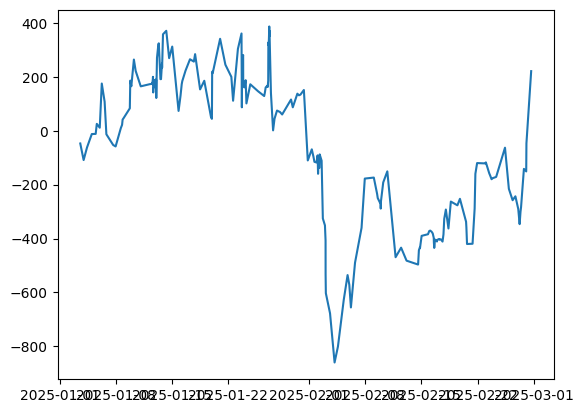

In [34]:
plt.plot(cumulative_profit_series)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  2.,  2.,  1.,  1.,  0.,  1.,  1.,  0.,
         4.,  0.,  1.,  4.,  1.,  5.,  0.,  4.,  5.,  2.,  7.,  4., 12.,
         7., 18., 21., 15., 16., 11.,  8.,  3.,  7.,  9.,  7.,  3.,  5.,
         1.,  2.,  0.,  0.,  2.,  0.,  2.,  2.,  0.,  0.,  1.,  4.,  0.,
         1.,  0.,  0.,  1.,  2.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-323.6720594 , -317.80649897, -311.94093855, -306.07537812,
        -300.20981769, -294.34425726, -288.47869683, -282.6131364 ,
        -276.74757597, -270.88201555, -265.01645512, -259.15089469,
        -253.28533426, -247.41977383, -241.5542134 , -235.68865297,
        -229.82309255, -223.95753212, -218.09197169, -212.22641126,
        -206.36085083, -200.4952904 , -194.62972998, -188.76416955,
        -182.89860912, -17

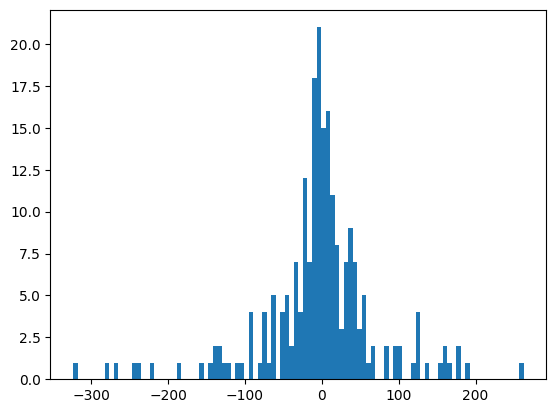

In [21]:
plt.hist(trade_profits, bins=100)

In [22]:
#Filter for negative values

trade_profits_neg = [x for x in trade_profits if x < 0]
print(f"Average trade loss:  € {np.mean(trade_profits_neg)}")

trade_profits_pos = [x for x in trade_profits if x > 0]
print(f"Average trade win:  € {np.mean(trade_profits_pos)}")

print("Number of negative profits(profits that were less than the transaction cost): ", len(trade_profits_neg))
print("Number of positive profits (profits that were greater than the transaction cost): ", len(trade_profits_pos))



Average trade loss:  € -48.98839798949971
Average trade win:  € 45.77158040862044
Number of negative profits(profits that were less than the transaction cost):  115
Number of positive profits (profits that were greater than the transaction cost):  104


In [23]:
# #Calculate returns based on the trade profits
# trade_profits = np.array(trade_profits)
# returns = trade_profits/initial_capital * 100

# #Plot the returns
# plt.hist(returns, bins=50, edgecolor='black')
# plt.xlabel('Returns (%)')   
# plt.ylabel('Frequency')
# plt.title(f'Returns Distribution for Pair {sym1} and {sym2}') 

In [24]:
# #Calculate percentage price changes for each asset
# price_changes_S1 = np.array(price_changes_S1)

In [25]:
# #Obtain non-zero price changes
# price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
# price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

# #Convert price changes to percentage
# price_changes_S1_non_zero_percent = [(x*100) for x in price_changes_S1_non_zero]
# price_changes_S2_non_zero_percent = [(x*100) for x in price_changes_S2_non_zero]

# #Print average price changes
# print(f"Average price change S1: {np.mean(price_changes_S1_non_zero_percent)} %", f"Average price change S1: {np.mean(price_changes_S2_non_zero_percent)} %")
# print(f"Number of trades: {len(price_changes_S1_non_zero)}")

In [26]:
# percentage_return = cumulative_profit_series[-1]/initial_capital * 100
# print(f"Percentage return: {percentage_return:.2f} %")


# #PROFIT SHOULD BE 0.15 EUR

# plt.figure(figsize=(10,6))
# plt.plot(cumulative_profit_series)
# plt.title('Cumulative PnL')
# plt.xlabel('Time')
# plt.ylabel('PnL (EUR)')
# plt.show()

Number of trade entries: 0
Number of trade exits: 0
Total paired trades: 0
Trades in window:


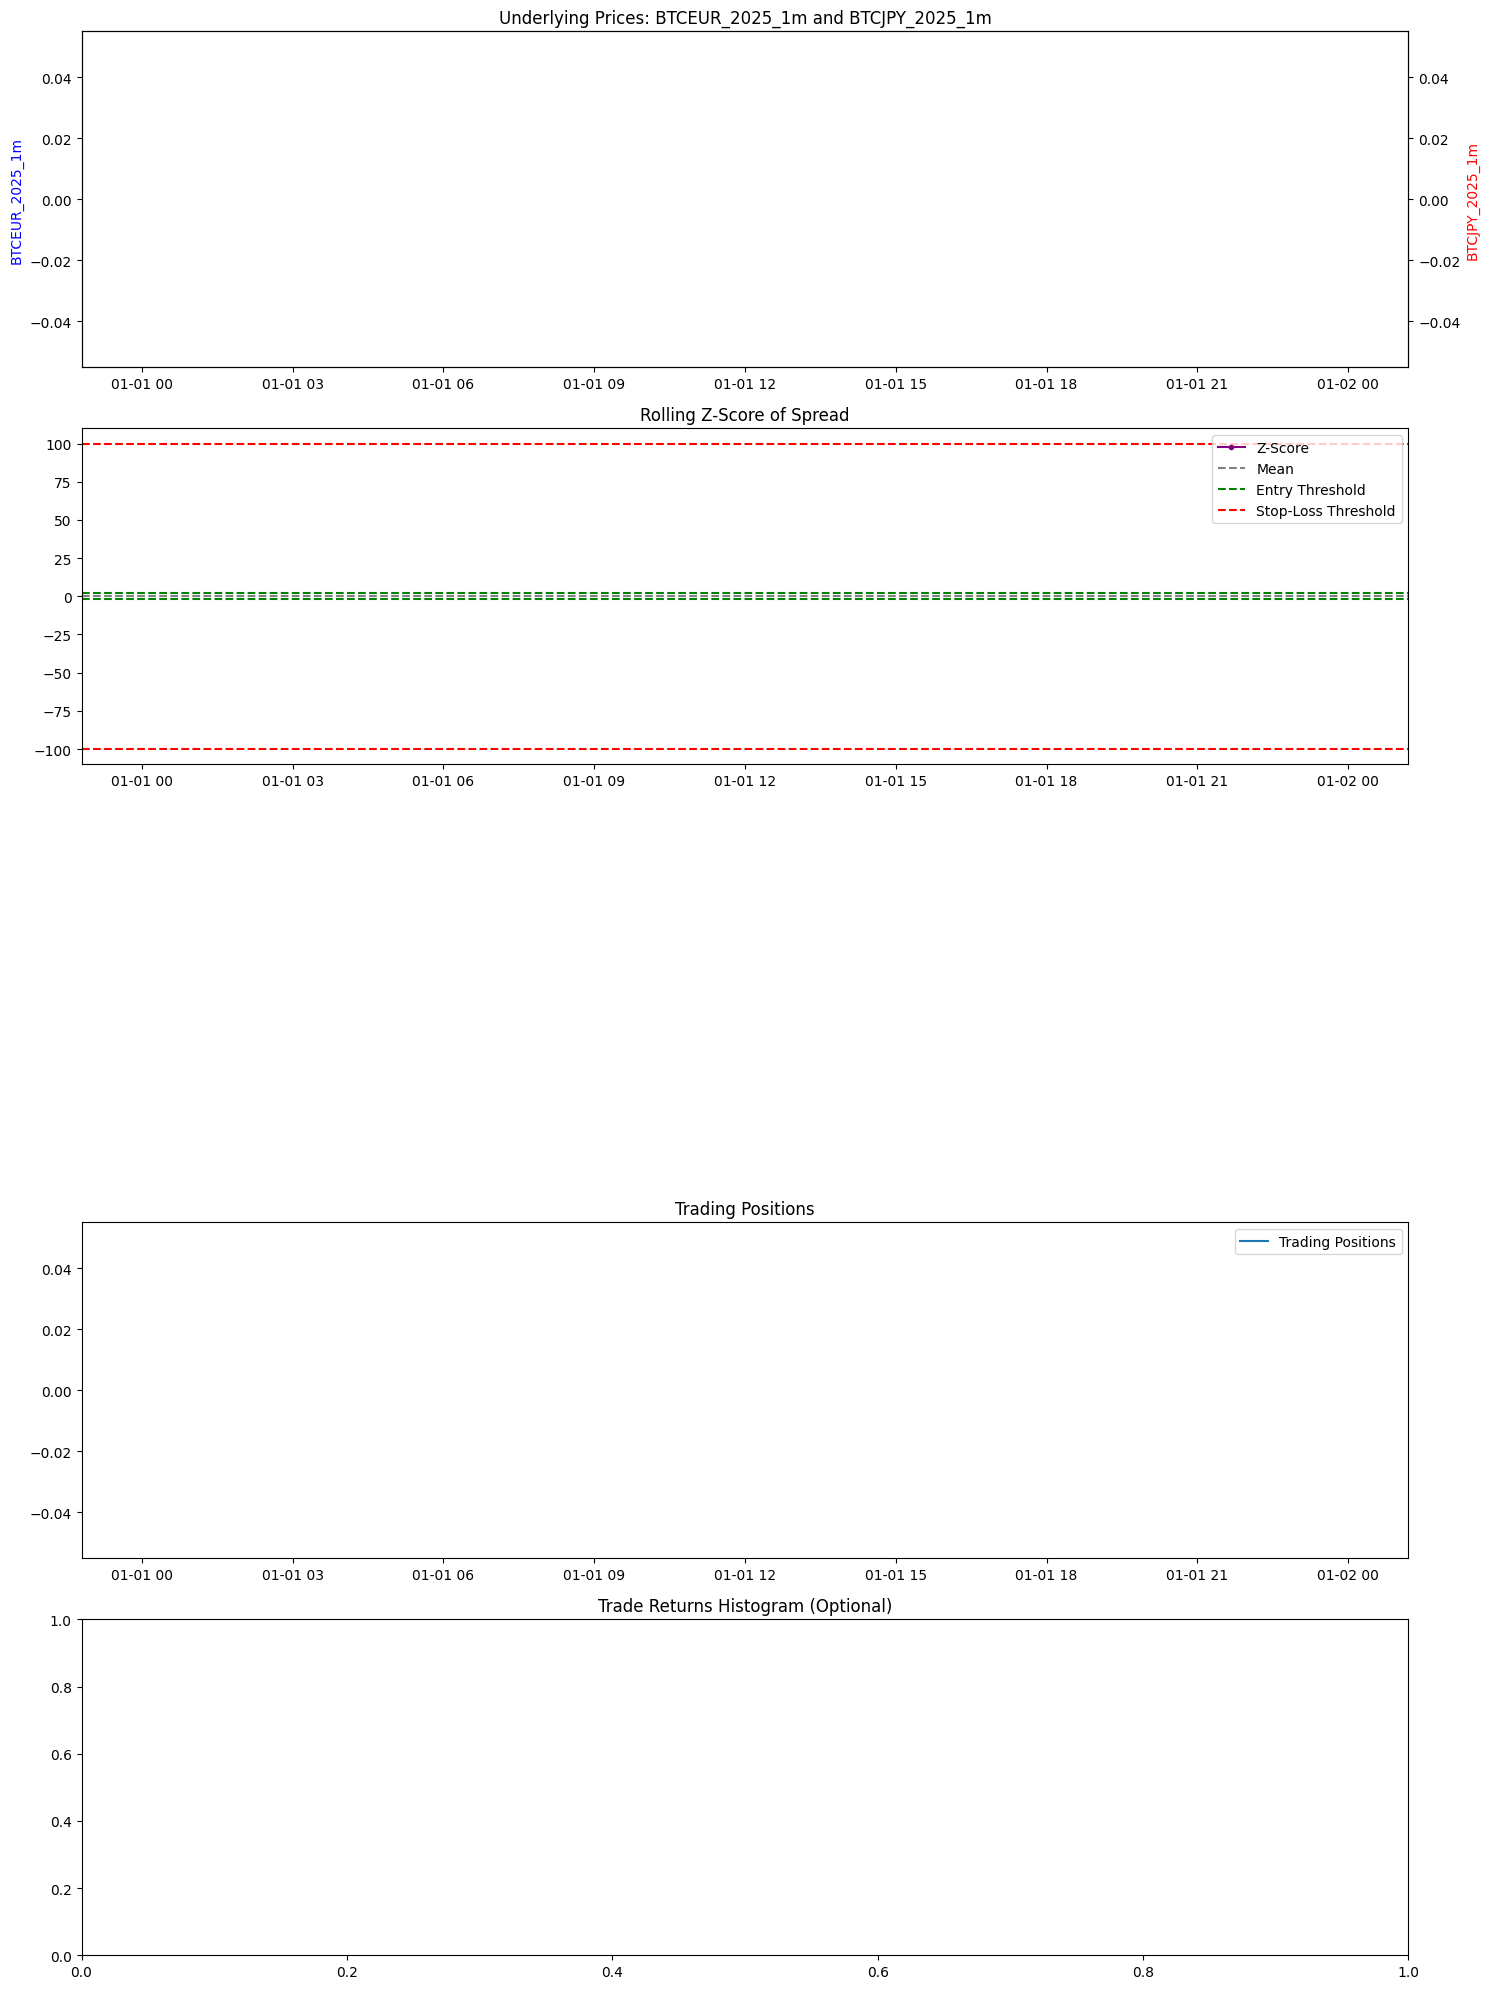

In [27]:
#Plot trading simulation
window_start = pd.to_datetime('2023-10-03 00:00:00')
window_end = pd.to_datetime('2023-10-03 20:00:00')


# window_start = pd.to_datetime('2024-03-05 08:00:00')
# window_end = pd.to_datetime('2024-03-08 15:00:00')

# window_start = None
# window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES

plot_trading_simulation(
    S1, 
    S2, 
    sym1, 
    sym2, 
    zscore_series, 
    positions, 
    entry_threshold,
    stop_loss_threshold,
    trade_entries=trade_entries,  # list of dicts: { 'time', 'S1', 'S2', 'z', 'position' }
    trade_exits=trade_exits,    # list of dicts: { 'time', 'S1', 'S2', 'z', 'exit_type' }
    window_start=window_start,
    window_end=window_end
)



In [28]:
z = 0.1

if z < -0:
    print("Short")

In [29]:


# #Get prices at the start and end of the first trade
# S1_price_start = S1[entry_indices]
# S2_price_start = S2[entry_indices]

# S1_price_end = S1.loc[exit_indices]
# S2_price_end = S2.loc[exit_indices]


# #Calculate the price changes by converting the series to numpy arrays
# S1_price_start = S1_price_start.to_numpy()
# S2_price_start = S2_price_start.to_numpy()

# S1_price_end = S1_price_end.to_numpy()
# S2_price_end = S2_price_end.to_numpy()

# print("BEFORE ALIGNMENT")

# #Make sure the arrays have the same shape
# print(S1_price_start.shape)
# print(S2_price_start.shape)


# print(S1_price_end.shape)
# print(S2_price_end.shape)


# if S1_price_start.shape > S1_price_end.shape:
#     S1_price_start = S1_price_start[:len(S1_price_end)]

# if S2_price_start.shape > S2_price_end.shape:
#     S2_price_start = S2_price_start[:len(S2_price_end)]
 
# print("AFTER ALIGNMENT")

# #Make sure the arrays have the same shape
# print(S1_price_start.shape)
# print(S2_price_start.shape)

# print(S1_price_end.shape)
# print(S2_price_end.shape)

# #Get the price changes
# S1_price_change = S1_price_end - S1_price_start
# S2_price_change = S2_price_end - S2_price_start

# #Get percentage price changes
# S1_price_change_percent = S1_price_change/S1_price_start * 100
# S2_price_change_percent = S2_price_change/S2_price_start * 100

# #Get absolute percentage price changes
# S1_price_change_percent_abs = np.abs(S1_price_change_percent)
# S2_price_change_percent_abs = np.abs(S2_price_change_percent)


# print(f"Average absolute S1 price change percent: {np.mean(S1_price_change_percent_abs):.2f}%")
# print(f"Average absolute S2 price change percent: {np.mean(S2_price_change_percent_abs):.2f}%")

# print(f"Average of average absolute price changes: {(np.mean(S1_price_change_percent_abs) + np.mean(S2_price_change_percent_abs))/2:.2f}%")



# # #Get the price changes
# # S1_price_change = S1_price_end - S1_price_start
# # S2_price_change = S2_price_end - S2_price_start


In [30]:
#Print average S1 price change percent rounded to 2 decimal places

#Average Absolute Percentage Reversion
#---------------------------------------


In [31]:

def calculate_avg_abs_pct_reversion(trade_entries, trade_exits):
    """
    Calculate the average absolute percentage reversion from trade entry to trade exit
    for both asset price series (S1 and S2), using the interpolated trade data.
    
    Args:
        trade_entries (list): List of dictionaries for trade entries.
            Each dict should have keys: 'time', 'S1', 'S2', 'z', 'position'
        trade_exits (list): List of dictionaries for trade exits.
            Each dict should have keys: 'time', 'S1', 'S2', 'z', 'exit_type'
    
    Returns:
        overall_avg (float): The average of the average absolute percentage changes for S1 and S2.
    """
    S1_pct_changes = []
    S2_pct_changes = []
    
    # Loop over paired trade entries and exits.
    for entry, exit in zip(trade_entries, trade_exits):
        entry_S1 = entry['S1']
        entry_S2 = entry['S2']
        exit_S1 = exit['S1']
        exit_S2 = exit['S2']
        
        # Calculate absolute percentage change for each asset.
        pct_change_S1 = np.abs((exit_S1 - entry_S1) / entry_S1 * 100)
        pct_change_S2 = np.abs((exit_S2 - entry_S2) / entry_S2 * 100)
        
        S1_pct_changes.append(pct_change_S1)
        S2_pct_changes.append(pct_change_S2)
    
    # Compute the average absolute percentage change for S1 and S2.
    avg_abs_S1 = np.mean(S1_pct_changes) if S1_pct_changes else 0
    avg_abs_S2 = np.mean(S2_pct_changes) if S2_pct_changes else 0
    
    # Overall average is the average of the two.
    overall_avg = (avg_abs_S1 + avg_abs_S2) / 2
    
    print(f"Average absolute S1 price change percent: {avg_abs_S1:.2f}%")
    print(f"Average absolute S2 price change percent: {avg_abs_S2:.2f}%")
    print(f"Average of average absolute price changes: {overall_avg:.2f}%")
    
    return overall_avg



In [32]:
overall_avg_reversion = calculate_avg_abs_pct_reversion(trade_entries, trade_exits)

Average absolute S1 price change percent: 0.48%
Average absolute S2 price change percent: 0.53%
Average of average absolute price changes: 0.51%
